# メーカーごとのデータ数が極端に少ない値を外れ値にして予測  
# encodingをダミーエンコーディングで実装

In [1]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score,mean_absolute_percentage_error

import lightgbm as lgb
import optuna.integration.lightgbm as opt_lgb
import optuna
import matplotlib.pyplot as plt
import japanize_matplotlib

looker studioでパレート図(横軸メーカー、縦軸データ数)を作った結果  
下位10メーカーはデータが2個以下しかないため、使用できないと判断し、外れ値とした。

In [2]:
#データの読み込み
train_data = pd.read_csv("../data/機械学習用/train_data.csv",index_col=0)
model_data = pd.read_csv('../data/アップロード用/model_data.csv',index_col=0)
info_data = pd.read_csv('../data/アップロード用/bike_info.csv',index_col=0)
#サンプルサイズが少ないモデルを抽出
all_data = info_data.merge(model_data,on='model_number',how='left')
brand_count = all_data.groupby('brand').size().sort_values(ascending=True)
#下位10メーカーを抽出(上のcountデータがすでに照準のため上から９つを抽出する)
low_10 = brand_count.index[0:10]
model_data = model_data[~model_data['brand'].isin(low_10)]
#このメーカーデータを使ってtrainデータに結合
train_data = train_data.merge(model_data,on='model_number',how='left')
#先ほど外れ値に指定したデータはnullになるため、dropnaをすればok
train_data.dropna(inplace=True)

In [3]:
train_data

,id,cost,model_number,model_year,color,mileage,guarantee_period,store_id,brand,name,type,displacement
0,2100006155617,118000,JBH-AF67,2012.0,黒,2742.0,0.25,51,HONDA,ﾄｩﾃﾞｲ,スクーター/ビッグスクーター,50.0
1,2100004366077,1378000,EBL-NC42,2019.0,黒,776.0,5.00,2,HONDA,CB400 SUPER FOUR HYPER VTEC Revo,ネイキッド,400.0
2,2100005457217,348000,JBK-ER250C,2013.0,白,11979.0,1.00,58,KAWASAKI,Z250,ネイキッド,250.0
3,2100005346689,568000,JUE4,2021.0,黒,5688.0,5.00,81,Husqvarna,SVARTPILEN 250,ネイキッド,250.0
4,2100005410144,458000,JBK-RG10J,2019.0,青,27167.0,1.00,37,YAMAHA,YZFR25,スポーツ/ツアラー,250.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4484,2100006097726,1018000,8BL-RM39J,2022.0,青,2964.0,7.00,67,YAMAHA,YZFR7,スポーツ/ツアラー,700.0
4485,2100006214697,798000,BC-SK44A,2008.0,黒,11745.0,0.25,3,SUZUKI,DRZ400SM,オフロード/モタード,400.0
4486,2100006202625,1198000,EBL-SC59,2013.0,オレンジ,23013.0,1.00,74,HONDA,CBR1000RR,スポーツ/ツアラー,1000.0
4487,2100006271508,466000,JBK-RG10J,2019.0,赤,5895.0,5.00,54,YAMAHA,YZFR25,スポーツ/ツアラー,250.0


# モデルの作成  
使用する特徴量  
* model_year
* color
* mileage 
* gurantee_period
* brand
* type
* displacement  

In [4]:
#ダミーエンコーディング  
#色、ブランド、typeは名義尺度のため、本来ラベルエンコーディングは不適当なため、dummy変数化
#oe =OrdinalEncoder()
#エンコーディングしたい列
encoding_target = ['color','brand','type']
#train_data[encoding_target] = oe.fit_transform(train_data[encoding_target].values)

In [5]:
train_data=pd.get_dummies(train_data,drop_first=True,columns=encoding_target)

In [6]:
#説明変数と目的変数の抽出
X = train_data.iloc[:,2:].drop(columns=['model_number','name','store_id']).values
y = train_data['cost'].values

In [7]:
#学習データと検証データへの分割
X_learn,X_val,y_learn,y_val = train_test_split(X,y,test_size=0.2,random_state=123)

In [8]:
lr_ds = opt_lgb.Dataset(X_learn,y_learn)
val_ds = opt_lgb.Dataset(X_val,y_val)

#固定するparamsは先に指定
params ={
    'objective':'regression',
    'metric':'mape'
}

#クロスバリデーションによるパラメータの探索 5Fold
tuner = opt_lgb.LightGBMTunerCV(params,
                                lr_ds,
                                num_boost_round=10000,
                                verbose_eval=100,
                                early_stopping_rounds=100,
                                folds =KFold(n_splits=5))

tuner.run()

[I 2023-12-05 15:13:32,373] A new study created in memory with name: no-name-20afc166-8a1a-4f0f-875c-e31dbfc8cf44
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000135 seconds.
You can set `force_row_wise=true` t

feature_fraction, val_score: 0.177748:  14%|#4        | 1/7 [00:02<00:14,  2.46s/it]

Early stopping, best iteration is:
[84]	cv_agg's valid mape: 0.177748 + 0.00798786
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

feature_fraction, val_score: 0.177748:  29%|##8       | 2/7 [00:05<00:13,  2.68s/it]

Early stopping, best iteration is:
[137]	cv_agg's valid mape: 0.181961 + 0.00674136
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threadin

feature_fraction, val_score: 0.177748:  43%|####2     | 3/7 [00:08<00:11,  2.86s/it]

Early stopping, best iteration is:
[133]	cv_agg's valid mape: 0.179974 + 0.00728752
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threadin

feature_fraction, val_score: 0.177748:  57%|#####7    | 4/7 [00:11<00:08,  2.79s/it]

Early stopping, best iteration is:
[130]	cv_agg's valid mape: 0.178818 + 0.00654407
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threadin

feature_fraction, val_score: 0.177748:  71%|#######1  | 5/7 [00:13<00:05,  2.80s/it]

Early stopping, best iteration is:
[140]	cv_agg's valid mape: 0.185566 + 0.0043375
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

feature_fraction, val_score: 0.177748:  86%|########5 | 6/7 [03:10<01:01, 61.75s/it]

Early stopping, best iteration is:
[140]	cv_agg's valid mape: 0.1921 + 0.00592769
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading,

feature_fraction, val_score: 0.177748: 100%|##########| 7/7 [03:14<00:00, 27.72s/it]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[244]	cv_agg's valid mape: 0.201795 + 0.00657212


num_leaves, val_score: 0.177748:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of t

num_leaves, val_score: 0.166373:   5%|5         | 1/20 [01:54<36:18, 114.64s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[53]	cv_agg's valid mape: 0.166373 + 0.00585203
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise mu

num_leaves, val_score: 0.166373:  10%|#         | 2/20 [02:00<15:10, 50.59s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[52]	cv_agg's valid mape: 0.166749 + 0.00555862
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000255 seconds.
Y

num_leaves, val_score: 0.166373:  15%|#5        | 3/20 [02:06<08:31, 30.08s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[52]	cv_agg's valid mape: 0.166749 + 0.00555862
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41

num_leaves, val_score: 0.166373:  20%|##        | 4/20 [02:08<05:05, 19.08s/it]

Early stopping, best iteration is:
[84]	cv_agg's valid mape: 0.177748 + 0.00798786
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

num_leaves, val_score: 0.166373:  25%|##5       | 5/20 [02:13<03:33, 14.24s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

num_leaves, val_score: 0.166373:  30%|###       | 6/20 [02:19<02:39, 11.36s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[52]	cv_agg's valid mape: 0.166749 + 0.00555862
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41

num_leaves, val_score: 0.165481:  35%|###5      | 7/20 [02:24<02:01,  9.35s/it]

Early stopping, best iteration is:
[59]	cv_agg's valid mape: 0.165481 + 0.00603896
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

num_leaves, val_score: 0.165481:  40%|####      | 8/20 [02:28<01:30,  7.53s/it]

Early stopping, best iteration is:
[70]	cv_agg's valid mape: 0.166882 + 0.00768029
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

num_leaves, val_score: 0.165481:  45%|####5     | 9/20 [02:33<01:13,  6.67s/it]

Early stopping, best iteration is:
[62]	cv_agg's valid mape: 0.166182 + 0.00664189
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

num_leaves, val_score: 0.164732:  50%|#####     | 10/20 [02:38<01:00,  6.06s/it]

Early stopping, best iteration is:
[56]	cv_agg's valid mape: 0.164732 + 0.0056714
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading,

num_leaves, val_score: 0.164732:  55%|#####5    | 11/20 [02:41<00:46,  5.18s/it]

[700]	cv_agg's valid mape: 0.188997 + 0.00936604
Early stopping, best iteration is:
[639]	cv_agg's valid mape: 0.188655 + 0.00922832
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[Light

num_leaves, val_score: 0.164732:  60%|######    | 12/20 [02:46<00:42,  5.33s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

num_leaves, val_score: 0.164732:  65%|######5   | 13/20 [02:50<00:34,  4.86s/it]

Early stopping, best iteration is:
[65]	cv_agg's valid mape: 0.166651 + 0.00770535
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

num_leaves, val_score: 0.164732:  70%|#######   | 14/20 [02:56<00:30,  5.15s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[52]	cv_agg's valid mape: 0.166749 + 0.00555862
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the 

num_leaves, val_score: 0.164732:  75%|#######5  | 15/20 [03:01<00:25,  5.01s/it]

Early stopping, best iteration is:
[67]	cv_agg's valid mape: 0.165625 + 0.00614878
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

num_leaves, val_score: 0.164732:  80%|########  | 16/20 [03:06<00:20,  5.07s/it]

Early stopping, best iteration is:
[59]	cv_agg's valid mape: 0.165481 + 0.00603896
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

num_leaves, val_score: 0.164732:  85%|########5 | 17/20 [03:11<00:15,  5.11s/it]

Early stopping, best iteration is:
[53]	cv_agg's valid mape: 0.16674 + 0.00655693
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading,

num_leaves, val_score: 0.164732:  90%|######### | 18/20 [03:14<00:08,  4.36s/it]

Early stopping, best iteration is:
[72]	cv_agg's valid mape: 0.173732 + 0.00908242
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

num_leaves, val_score: 0.164732:  95%|#########5| 19/20 [03:19<00:04,  4.78s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[52]	cv_agg's valid mape: 0.166749 + 0.00555862
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000212 seconds.
You can set `f

num_leaves, val_score: 0.164732: 100%|##########| 20/20 [03:25<00:00, 10.26s/it]


Early stopping, best iteration is:
[59]	cv_agg's valid mape: 0.165481 + 0.00603896


bagging, val_score: 0.164732:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002258 seconds.
You can set `force_col_wise=true` t

bagging, val_score: 0.164732:  10%|#         | 1/10 [00:02<00:25,  2.88s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[64]	cv_agg's valid mape: 0.178606 + 0.00763884
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.0002

bagging, val_score: 0.164425:  20%|##        | 2/10 [00:08<00:33,  4.23s/it]

Early stopping, best iteration is:
[52]	cv_agg's valid mape: 0.164425 + 0.00653045
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

bagging, val_score: 0.164425:  30%|###       | 3/10 [00:13<00:33,  4.80s/it]

Early stopping, best iteration is:
[68]	cv_agg's valid mape: 0.165598 + 0.00582518
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

bagging, val_score: 0.164425:  40%|####      | 4/10 [00:18<00:29,  4.87s/it]

Early stopping, best iteration is:
[60]	cv_agg's valid mape: 0.165327 + 0.00748337
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

bagging, val_score: 0.164425:  50%|#####     | 5/10 [00:24<00:25,  5.10s/it]

Early stopping, best iteration is:
[61]	cv_agg's valid mape: 0.165355 + 0.00628725
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

bagging, val_score: 0.164425:  60%|######    | 6/10 [00:29<00:20,  5.22s/it]

Early stopping, best iteration is:
[59]	cv_agg's valid mape: 0.166081 + 0.00685974
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

bagging, val_score: 0.164425:  70%|#######   | 7/10 [00:35<00:16,  5.42s/it]

Early stopping, best iteration is:
[70]	cv_agg's valid mape: 0.165231 + 0.00763845
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

bagging, val_score: 0.164425:  80%|########  | 8/10 [00:41<00:11,  5.52s/it]

Early stopping, best iteration is:
[71]	cv_agg's valid mape: 0.165908 + 0.00682435
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used featu

bagging, val_score: 0.164425:  90%|######### | 9/10 [00:46<00:05,  5.61s/it]

Early stopping, best iteration is:
[68]	cv_agg's valid mape: 0.168046 + 0.00719696
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

bagging, val_score: 0.164425: 100%|##########| 10/10 [00:52<00:00,  5.22s/it]


Early stopping, best iteration is:
[60]	cv_agg's valid mape: 0.167065 + 0.00666729


feature_fraction_stage2, val_score: 0.164425:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000226 seconds.
You can set `force_col_wise=true` t

feature_fraction_stage2, val_score: 0.163833:  33%|###3      | 1/3 [00:05<00:11,  5.68s/it]

Early stopping, best iteration is:
[63]	cv_agg's valid mape: 0.163833 + 0.0063731
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used featur

feature_fraction_stage2, val_score: 0.163833:  67%|######6   | 2/3 [00:11<00:05,  5.48s/it]

Early stopping, best iteration is:
[52]	cv_agg's valid mape: 0.164425 + 0.00653045
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

feature_fraction_stage2, val_score: 0.163833: 100%|##########| 3/3 [00:16<00:00,  5.44s/it]


Early stopping, best iteration is:
[53]	cv_agg's valid mape: 0.163961 + 0.00635111


regularization_factors, val_score: 0.163833:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of t

regularization_factors, val_score: 0.163833:   5%|5         | 1/20 [00:05<01:52,  5.94s/it]

Early stopping, best iteration is:
[65]	cv_agg's valid mape: 0.165058 + 0.00584548
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

regularization_factors, val_score: 0.163833:  10%|#         | 2/20 [00:11<01:44,  5.82s/it]

Early stopping, best iteration is:
[66]	cv_agg's valid mape: 0.163971 + 0.00677984
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

regularization_factors, val_score: 0.163833:  15%|#5        | 3/20 [00:17<01:38,  5.82s/it]

Early stopping, best iteration is:
[66]	cv_agg's valid mape: 0.163971 + 0.00677984
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

regularization_factors, val_score: 0.163833:  20%|##        | 4/20 [00:23<01:32,  5.79s/it]

Early stopping, best iteration is:
[66]	cv_agg's valid mape: 0.163971 + 0.00677984
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

regularization_factors, val_score: 0.163833:  25%|##5       | 5/20 [00:28<01:26,  5.76s/it]

Early stopping, best iteration is:
[66]	cv_agg's valid mape: 0.163971 + 0.00677984
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used featu

regularization_factors, val_score: 0.163833:  30%|###       | 6/20 [00:34<01:21,  5.84s/it]

Early stopping, best iteration is:
[66]	cv_agg's valid mape: 0.163971 + 0.00677984
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

regularization_factors, val_score: 0.163833:  35%|###5      | 7/20 [00:40<01:15,  5.81s/it]

Early stopping, best iteration is:
[66]	cv_agg's valid mape: 0.163971 + 0.00677984
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

regularization_factors, val_score: 0.163702:  40%|####      | 8/20 [00:46<01:09,  5.75s/it]

Early stopping, best iteration is:
[61]	cv_agg's valid mape: 0.163702 + 0.00667537
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

regularization_factors, val_score: 0.163702:  45%|####5     | 9/20 [00:51<01:02,  5.71s/it]

Early stopping, best iteration is:
[65]	cv_agg's valid mape: 0.164768 + 0.00699766
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

regularization_factors, val_score: 0.163702:  50%|#####     | 10/20 [00:57<00:55,  5.59s/it]

Early stopping, best iteration is:
[55]	cv_agg's valid mape: 0.164627 + 0.00622097
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing row-wise multi-threading

regularization_factors, val_score: 0.163702:  55%|#####5    | 11/20 [01:02<00:50,  5.56s/it]

Early stopping, best iteration is:
[55]	cv_agg's valid mape: 0.164627 + 0.00622097
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing row-wise multi-threading

regularization_factors, val_score: 0.163702:  60%|######    | 12/20 [01:08<00:45,  5.75s/it]

Early stopping, best iteration is:
[66]	cv_agg's valid mape: 0.163992 + 0.00678993
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

regularization_factors, val_score: 0.163702:  65%|######5   | 13/20 [01:14<00:40,  5.76s/it]

Early stopping, best iteration is:
[65]	cv_agg's valid mape: 0.163906 + 0.0067699
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading,

regularization_factors, val_score: 0.163702:  70%|#######   | 14/20 [01:20<00:34,  5.73s/it]

Early stopping, best iteration is:
[65]	cv_agg's valid mape: 0.163906 + 0.0067699
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading,

regularization_factors, val_score: 0.163702:  75%|#######5  | 15/20 [01:25<00:28,  5.69s/it]

Early stopping, best iteration is:
[61]	cv_agg's valid mape: 0.163739 + 0.00656722
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

regularization_factors, val_score: 0.163702:  80%|########  | 16/20 [01:31<00:22,  5.63s/it]

Early stopping, best iteration is:
[61]	cv_agg's valid mape: 0.163739 + 0.00656722
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

regularization_factors, val_score: 0.163666:  85%|########5 | 17/20 [01:37<00:16,  5.65s/it]

Early stopping, best iteration is:
[61]	cv_agg's valid mape: 0.163666 + 0.00661452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

regularization_factors, val_score: 0.163476:  90%|######### | 18/20 [01:42<00:11,  5.69s/it]

Early stopping, best iteration is:
[68]	cv_agg's valid mape: 0.163476 + 0.00686766
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

regularization_factors, val_score: 0.163476:  95%|#########5| 19/20 [01:48<00:05,  5.66s/it]

Early stopping, best iteration is:
[63]	cv_agg's valid mape: 0.164075 + 0.0064693
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading,

regularization_factors, val_score: 0.163476: 100%|##########| 20/20 [01:54<00:00,  5.71s/it]


Early stopping, best iteration is:
[67]	cv_agg's valid mape: 0.164091 + 0.00608773


min_data_in_leaf, val_score: 0.163476:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_col_wise=true` t

min_data_in_leaf, val_score: 0.161500:  20%|##        | 1/5 [00:05<00:22,  5.53s/it]

Early stopping, best iteration is:
[68]	cv_agg's valid mape: 0.1615 + 0.00727924
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, 

min_data_in_leaf, val_score: 0.157583:  40%|####      | 2/5 [00:11<00:16,  5.57s/it]

Early stopping, best iteration is:
[71]	cv_agg's valid mape: 0.157583 + 0.00800216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading

min_data_in_leaf, val_score: 0.157583:  60%|######    | 3/5 [00:16<00:10,  5.49s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[68]	cv_agg's valid mape: 0.167006 + 0.00630329
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000285 seconds.
Y

min_data_in_leaf, val_score: 0.157583:  80%|########  | 4/5 [00:20<00:04,  4.73s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

min_data_in_leaf, val_score: 0.157583: 100%|##########| 5/5 [00:22<00:00,  4.52s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [21]:
best_params = tuner.best_params
best_params

{'objective': 'regression',
 'metric': 'mape',
 'feature_pre_filter': False,
 'lambda_l1': 4.1530828743432944e-07,
 'lambda_l2': 1.3155662048591278e-05,
 'num_leaves': 86,
 'feature_fraction': 0.9520000000000001,
 'bagging_fraction': 0.9732965502345418,
 'bagging_freq': 7,
 'min_child_samples': 5}

In [22]:
tuner.best_score

0.15758303441027163

In [23]:
model_2 = lgb.train(best_params,
                    train_set= lr_ds,
                    valid_sets=val_ds,
                    num_boost_round=100,
                    callbacks=[lgb.early_stopping(stopping_rounds=100,verbose=100)])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 3585, number of used features: 28
[LightGBM] [Info] Start training from score 724882.033473
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's mape: 0.15753


In [24]:
predict_learn = model_2.predict(X_learn)
predict_val = model_2.predict(X_val)
print('学習データMAPE',mean_absolute_percentage_error(y_pred=predict_learn,y_true=y_learn))
print('検証データMAPE',mean_absolute_percentage_error(y_pred=predict_val,y_true=y_val))
print('学習データr_2',r2_score(y_true=y_learn,y_pred=predict_learn))
print('検証データr_2',r2_score(y_true=y_val,y_pred=predict_val))

学習データMAPE 0.08519415831323958
検証データMAPE 0.1575304558459797
学習データr_2 0.9811120129293163
検証データr_2 0.8247014650777253


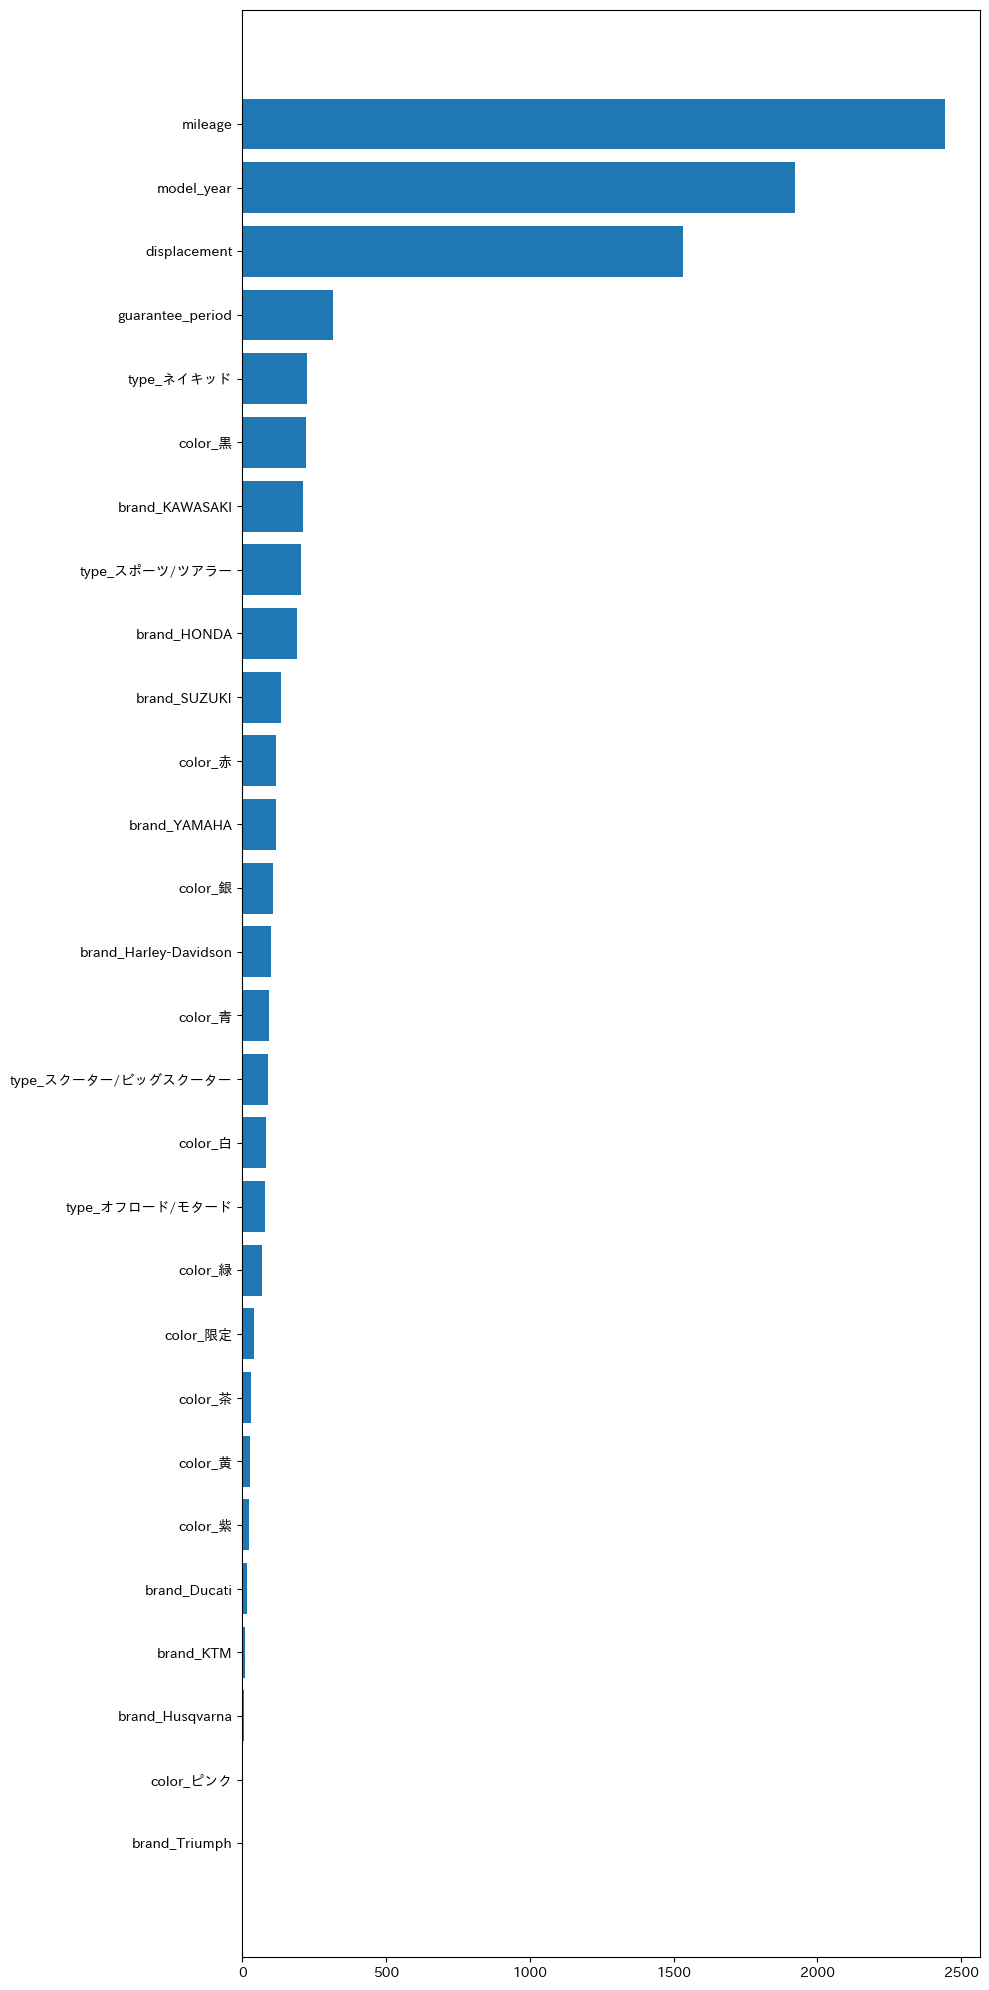

In [25]:
#feature_importanceも確認してみる
plt.subplots(figsize=(10,20))
featuer_name = train_data.drop(columns=['id','cost','model_number','name','store_id']).columns
importances = model_2.feature_importance()
indices = np.argsort(importances)
plt.barh(np.asarray(featuer_name)[indices],importances[indices])
plt.tight_layout()
plt.show()


In [26]:
test_data = pd.read_csv('../data/機械学習用/test_data.csv',index_col=0)
test_data=test_data.merge(model_data,on='model_number',how='left')
test_data.dropna(inplace=True)

In [27]:
test_data

,id,cost,model_number,model_year,color,mileage,guarantee_period,store_id,brand,name,type,displacement
0,2100005197021,128000,EBJ-SE53J,2011.0,銀,9937.0,0.25,64,YAMAHA,ｱｸｼｽﾄﾘｰﾄ,スクーター/ビッグスクーター,125.0
1,2100006010725,148000,BA-AF58,2004.0,黒,9317.0,0.25,75,HONDA,ｽﾞｰﾏｰ,スクーター/ビッグスクーター,50.0
2,2100006174472,598000,2BK-MC49,2020.0,青,1000.0,5.00,50,HONDA,ﾚﾌﾞﾙ250,アメリカン/クルーザー,250.0
3,2100005171830,458000,2BJ-JC79,2021.0,銀,4349.0,1.00,61,HONDA,CB125R,ネイキッド,125.0
4,2100006114140,158000,JBH-AF77,2019.0,緑,22.0,1.00,21,HONDA,ｼﾞｮﾙﾉ,スクーター/ビッグスクーター,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1117,2100006064599,138000,2BH-AF79,2016.0,銀,4610.0,0.25,21,HONDA,ﾀｸﾄﾍﾞｰｼｯｸ,スクーター/ビッグスクーター,50.0
1118,2100004942059,648000,JBK-BJ250A,2017.0,オレンジ,12514.0,3.00,43,KAWASAKI,ｴｽﾄﾚﾔ,ネイキッド,250.0
1119,2100005245517,2098000,8BL-EJ11A,2022.0,銀,1446.0,7.00,10,SUZUKI,ﾊﾔﾌﾞｻ,スポーツ/ツアラー,1300.0
1120,2100006294828,498000,BC-RH01J,2007.0,黒,2506.0,0.25,3,YAMAHA,SR400,ネイキッド,400.0


In [28]:
#ダミーエンコーディング
test_data = pd.get_dummies(test_data,drop_first=True,columns=encoding_target)


In [29]:
X_test=test_data.iloc[:,2:].drop(columns=['name','model_number','store_id']).values
y_test = test_data['cost'].values

In [30]:
train_ds = opt_lgb.Dataset(X,y)
test_ds = opt_lgb.Dataset(X_test,y_test)


model_2 = lgb.train(best_params,
                    train_set= train_ds,
                    valid_sets= test_ds,
                    num_boost_round=10000,
                    callbacks=[lgb.early_stopping(stopping_rounds=100,verbose=100)])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 421
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 28
[LightGBM] [Info] Start training from score 736169.908523
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[143]	valid_0's mape: 0.149218


In [31]:
predict_train = model_2.predict(X)
predict_test = model_2.predict(X_test)

In [32]:
print('訓練データ決定係数',r2_score(y_true=y,y_pred=predict_train))
print('テストデータ決定係数',r2_score(y_true=y_test,y_pred=predict_test))
print('訓練データMAPE',mean_absolute_percentage_error(y_true=y,y_pred=predict_train))
print('テストデータMAPE',mean_absolute_percentage_error(y_true=y_test,y_pred=predict_test))

訓練データ決定係数 0.9896380896435155
テストデータ決定係数 0.7591863774957366
訓練データMAPE 0.07879278220971758
テストデータMAPE 0.14921811965941842
